In [19]:
#!sudo apt-get install libhdf5-dev
#!pip install --user h5py

In [2]:
#!pip install --user tensorflow==1.4.1
#!pip install --user tensorflow-gpu==1.4.1
#!pip install --user keras==2.1.2

    100% |████████████████████████████████| 40.8MB 36kB/s eta 0:00:011
    100% |████████████████████████████████| 1.7MB 934kB/s eta 0:00:01
  Found existing installation: tensorflow-tensorboard 0.1.8
    Uninstalling tensorflow-tensorboard-0.1.8:
      Successfully uninstalled tensorflow-tensorboard-0.1.8
  Found existing installation: tensorflow 1.3.0
    Uninstalling tensorflow-1.3.0:
      Successfully uninstalled tensorflow-1.3.0
    100% |████████████████████████████████| 170.1MB 8.7kB/s ta 0:00:011
  Using cached Keras-2.1.2-py2.py3-none-any.whl
  Found existing installation: Keras 2.0.6
    Uninstalling Keras-2.0.6:
      Successfully uninstalled Keras-2.0.6


In [1]:
import tensorflow as tf
print(tf.__version__)

1.4.1


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():  
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())  


[u'/device:CPU:0', u'/device:GPU:0']


In [243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#from keras.utils import np_utils
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist


In [244]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# decoder convolution kernel size
num_conv = 2
batch_size = 200
original_img_size = (img_rows, img_cols, img_chns)

# number of clustering centroid 
n_class = 10
# the encoder final features dimension
latent_dim = 10
# full connection layer dimension
intermediate_dim = 128
# Variational AutoEncoder sampling parameter
epsilon_std = 1.0
epochs = 5
# DEC parameter, default is 1.0
alpha = 1.0

In [245]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

In [246]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


In [247]:
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

output_shape = (batch_size, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
# generate the original image
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

In [248]:
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
def vae_loss(x, x_decoded_mean_squash):
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
        K.flatten(x),
        K.flatten(x_decoded_mean_squash))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)    
    return K.mean(xent_loss + kl_loss)
#vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 1)    5           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   320         conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   16448       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

In [249]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

('x_train.shape:', (60000, 28, 28, 1))


In [8]:
l0 = vae.get_layer("conv2d_1")
l0.get_weights()

[array([[[[-0.76343316]],
 
         [[ 0.73689955]]],
 
 
        [[[-0.83571875]],
 
         [[-0.84227437]]]], dtype=float32), array([ 0.], dtype=float32)]

In [250]:
import os
if os.path.isfile("vae_cnn_10.hdf5"):
    vae.load_weights("vae_cnn_10.hdf5")
else:
    vae.fit(x_train, x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test))
    vae.save_weights("vae_cnn_10.hdf5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 77s 1ms/step - loss: 164.6885 - val_loss: 136.5181
Epoch 2/5
60000/60000 [==============================] - 76s 1ms/step - loss: 120.7185 - val_loss: 112.1429
Epoch 3/5
60000/60000 [==============================] - 75s 1ms/step - loss: 108.9535 - val_loss: 107.6882
Epoch 4/5
60000/60000 [==============================] - 75s 1ms/step - loss: 103.7177 - val_loss: 102.6471
Epoch 5/5
60000/60000 [==============================] - 77s 1ms/step - loss: 100.7167 - val_loss: 98.7324


In [251]:
# build a model to project inputs on the latent space
encoder = Model(x, z)
# display a 3D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)


In [11]:
l1 = encoder.get_layer("conv2d_1")
l2 = vae.get_layer("conv2d_1")

In [12]:
l1.get_weights()

[array([[[[-0.32273221]],
 
         [[ 0.58459383]]],
 
 
        [[[ 0.02223823]],
 
         [[-0.18091546]]]], dtype=float32),
 array([ 0.01339213], dtype=float32)]

In [13]:
l2.get_weights()

[array([[[[-0.32273221]],
 
         [[ 0.58459383]]],
 
 
        [[[ 0.02223823]],
 
         [[-0.18091546]]]], dtype=float32),
 array([ 0.01339213], dtype=float32)]

In [252]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
try:
    sparkContext.stop() 
except:
    pass
conf = SparkConf()

In [253]:
#spark = SparkSession.builder.getOrCreate()
spark = SparkSession \
    .builder \
    .master("spark://liyw:7077") \
    .appName("vae_unsupervized") \
    .config("spark.some.config.option", "") \
    .getOrCreate()

In [254]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA

m_data = []
for i in range(len(x_test_encoded)):
        m_data.append((Vectors.dense(x_test_encoded[i]),))

df_encoder = spark.createDataFrame(m_data, ["features"])
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model_pca = pca.fit(df_encoder)
#centers = model.clusterCenters()
features = model_pca.transform(df_encoder).select("pcaFeatures")
features = np.array(features.rdd.map(lambda x: [x[0][0], x[0][1], x[0][2]]).collect(), dtype='float32')


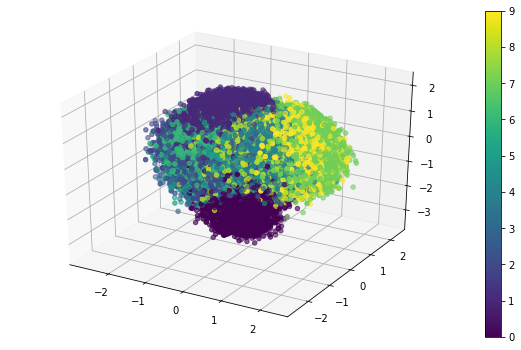

In [255]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.scatter(features[:, 2], features[:, 1], features[:, 0], c=y_train)

fig.colorbar(surf)

plt.show()

In [256]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

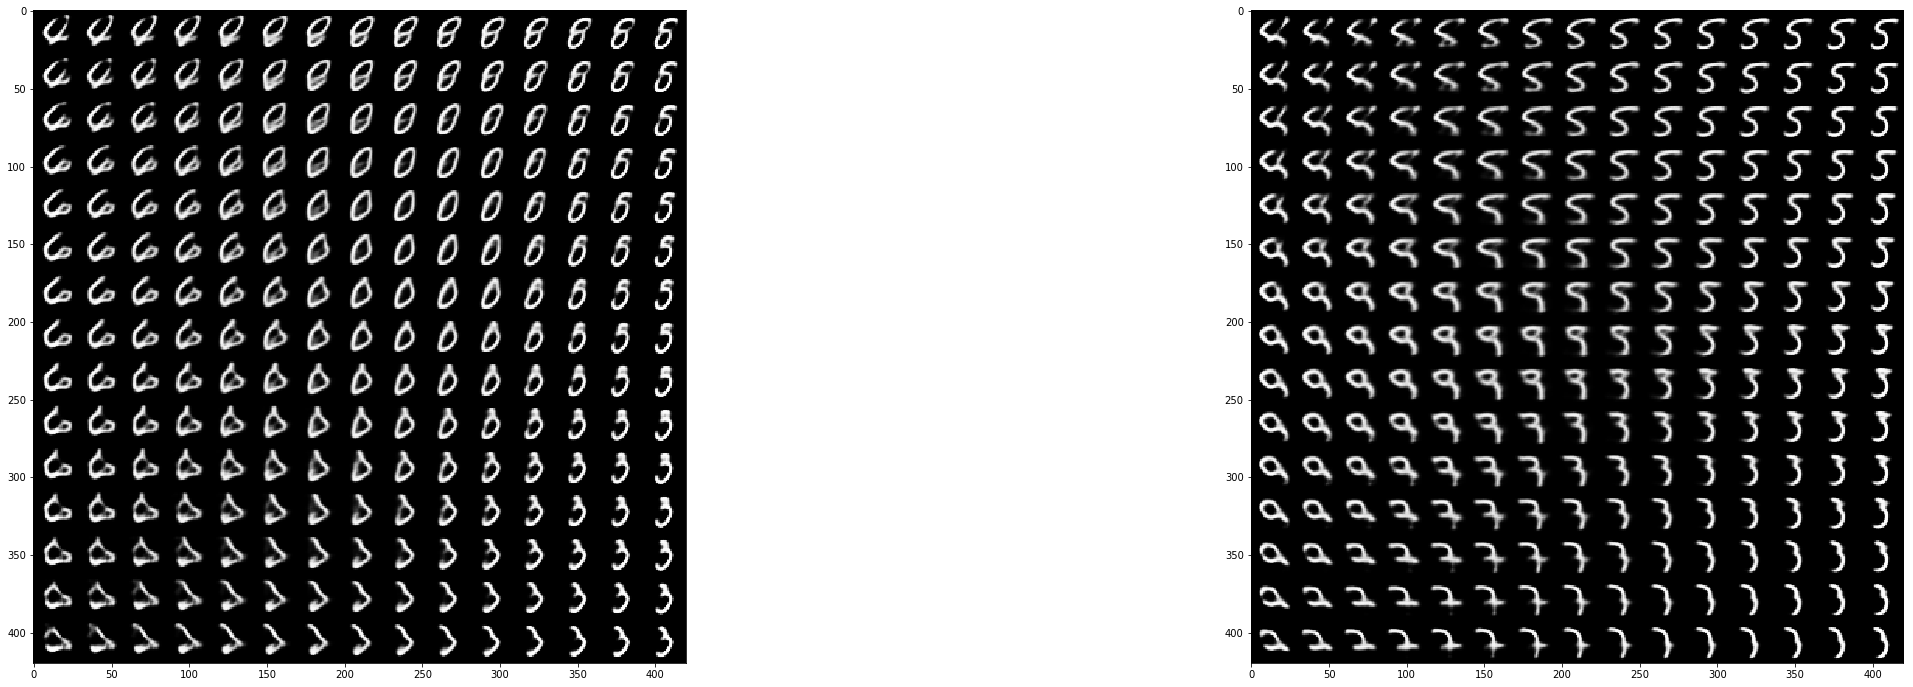

In [15]:
# display 5*3 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_z = norm.ppf(np.linspace(0.05, 0.95, n))

demo = True

if demo:
    fig = plt.figure(figsize=(40, 12))

    ix = 1
    for zi in range(-1, 2, 2):
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                data = []
                for k in range(int(latent_dim/2)-1):
                    data.append(yi)
                for k in range(int(latent_dim/2)-1):
                    data.append(xi)
                for k in range(2):
                    data.append(zi)
                z_sample = np.array([data])
                z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
                x_decoded = generator.predict(z_sample, batch_size=batch_size)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
        ax = fig.add_subplot(1, 2, ix)
        ix = ix + 1
        ax.imshow(figure, cmap='Greys_r')
    plt.show()
else:
    fig = plt.figure(figsize=(60, 36))

    for ix, zi in enumerate(grid_z):
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([[xi, yi, zi]])
                z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
                x_decoded = generator.predict(z_sample, batch_size=batch_size)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
        ax = fig.add_subplot(5, 5, ix + 1)
        ax.imshow(figure, cmap='Greys_r')
    plt.show()



In [257]:
from pyspark.ml.linalg import Vectors
from  pyspark.ml.clustering import KMeans

#m_data = []
#for i in range(len(x_test_encoded)):
#        m_data.append((Vectors.dense(x_test_encoded[i]),))

#df = spark.createDataFrame(m_data, ["features"])
kmeans = KMeans(k=10)
model = kmeans.fit(df_encoder)
centers = model.clusterCenters()
y_pred = model.transform(df_encoder).select("prediction")
y_pred = y_pred.rdd.map(lambda x: x[0]).collect()

In [258]:
lst_centers = []
for i in range(len(centers)):
    lst_centers.append(centers[i].tolist())

In [259]:
from keras.engine.topology import Layer
class ClusteringLayer(Layer):
    def __init__(self, output_dim, input_dim=None, alpha=1.0, weights=None, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha
        self.initial_weights = weights

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        #self.W = self.add_weight(name='W', 
        #                              shape = (self.output_dim, input_shape[1]),
        #                              initializer='uniform',
        #                              trainable=True)
        
        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]
        super(ClusteringLayer, self).build(input_shape)

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

In [260]:
from keras.models import Sequential
from keras.engine.topology import Layer, InputSpec
dec = Model(x, ClusteringLayer(n_class, weights=np.array(lst_centers, dtype='float32'), name='clustering')(z))
dec.compile(loss='kullback_leibler_divergence', optimizer='adadelta')
# set the inititialized cluster_centers weights from KMeans
dec.get_layer('clustering').set_weights([np.array(lst_centers, dtype='float32')])
#dec.summary()

In [261]:
dec.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 1)    5           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   320         conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   16448       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

In [263]:
l3 = dec.get_layer("conv2d_6")
l3.get_weights()

[array([[[[-0.59818923]],
 
         [[ 0.82394832]]],
 
 
        [[[-0.06421483]],
 
         [[ 0.27433604]]]], dtype=float32),
 array([ 0.05111807], dtype=float32)]

In [264]:
def cluster_acc(Y_pred, Y):
    from sklearn.utils.linear_assignment_ import linear_assignment
    D = max(max(Y_pred), max(Y))+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(len(Y_pred)):
        w[Y_pred[i], Y[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i,j] for i,j in ind])*1.0/len(Y_pred), w

In [265]:
update_interval = x_train.shape[0]/batch_size
train = True
iteration, index = 0, 0
acc = cluster_acc(y_pred, y_train)[0]
print('Accuracy '+str(np.round(acc, 5)))

Accuracy 0.60572


In [266]:
def compute_pij(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [268]:
%%time
import time as tm
if os.path.isfile("dec_weights_10.h5"):
    dec.load_weights("dec_weights_10.h5")
else:
    while train:
        if iteration % update_interval == 0:
            q = dec.predict(x_train, verbose=0)
            p = compute_pij(q)
            y_pred = q.argmax(1)
            acc = cluster_acc(y_pred, y_train)[0]
            if (iteration > 0):
                end = tm.time()
                print('iteration ' + str(iteration) + ', Accuracy '+str(np.round(acc, 5))+', time: '+str(end-start))
            start = tm.time()
        if (index+1)*batch_size >= x_train.shape[0]:
            loss = dec.train_on_batch(x_train[index*batch_size::], p[index*batch_size::])
            index = 0
            #print('Loss %f' % loss)
        else:
            loss = dec.train_on_batch(x_train[index*batch_size:(index+1)*batch_size],
                        p[index*batch_size:(index+1)*batch_size])
            #print('Loss %f' % loss)
            index += 1

        if iteration == update_interval * 30:
            train = False
        iteration += 1
    dec.save_weights('dec_weights_10.h5')

iteration 300, Accuracy 0.60878, time: 8.66649603844
iteration 600, Accuracy 0.61668, time: 9.27571105957
iteration 900, Accuracy 0.6284, time: 9.25487685204
iteration 1200, Accuracy 0.63837, time: 8.71351003647
iteration 1500, Accuracy 0.6462, time: 9.10949397087
iteration 1800, Accuracy 0.65165, time: 8.77119708061
iteration 2100, Accuracy 0.65585, time: 8.77606797218
iteration 2400, Accuracy 0.65892, time: 8.95434403419
iteration 2700, Accuracy 0.66137, time: 8.78727817535
iteration 3000, Accuracy 0.66307, time: 8.80013394356
iteration 3300, Accuracy 0.66527, time: 8.7656390667
iteration 3600, Accuracy 0.66628, time: 8.58898496628
iteration 3900, Accuracy 0.66783, time: 8.60643911362
iteration 4200, Accuracy 0.66867, time: 8.67317891121
iteration 4500, Accuracy 0.6695, time: 8.75019407272
iteration 4800, Accuracy 0.67038, time: 8.96200489998
iteration 5100, Accuracy 0.67085, time: 8.96906709671
iteration 5400, Accuracy 0.6716, time: 8.98109102249
iteration 5700, Accuracy 0.67208, ti

IOError: Unable to create file (unable to truncate a file which is already open)

In [27]:
index = 0

In [226]:
acc = cluster_acc(y_pred, y_train)[0]
q = dec.predict(x_train, verbose=0)
p = compute_pij(q)
#y_pr = q.argmax(1)
#delta_label = ((y_pr == y_pred).sum().astype(np.float32) / y_pr.shape[0])
#y_pred = y_pr
#for i in range(len(encoder.layers)):
#    encoder.layers[i].set_weights(dec.layers[i].get_weights())


In [204]:
p

array([[  9.97448862e-01,   9.90607587e-05,   1.24888436e-04, ...,
          1.04552208e-04,   7.51382831e-05,   7.72206695e-05],
       [  7.72190979e-05,   9.99407709e-01,   3.69683439e-05, ...,
          5.57503663e-05,   1.16606476e-04,   3.99930286e-05],
       [  9.94230213e-05,   5.42484850e-05,   8.25573152e-05, ...,
          8.14281448e-05,   7.32556509e-05,   2.41116984e-04],
       ..., 
       [  9.97733235e-01,   1.04350605e-04,   1.26220664e-04, ...,
          1.05538646e-04,   8.42838126e-05,   8.14470768e-05],
       [  5.63938011e-05,   1.10080218e-04,   9.13134791e-05, ...,
          3.85492312e-05,   9.99408841e-01,   2.29322923e-05],
       [  8.20352288e-04,   1.65398727e-04,   2.51477904e-04, ...,
          1.43753583e-04,   1.04517720e-04,   1.40215503e-04]], dtype=float32)

In [242]:
q = dec.predict(x_train, verbose=0)

cluster_acc(q.argmax(1), y_train)[0]

0.69596666666666662

In [238]:
for i in range(20):
    loss = dec.train_on_batch(x_train[index*batch_size:(index+1)*batch_size],
                        p[index*batch_size:(index+1)*batch_size])
    index += 1
    if index >= 300:
        index = 0

In [232]:
l3.get_weights()

[array([[[[-0.29900128]],
 
         [[ 0.69626093]]],
 
 
        [[[ 0.02225558]],
 
         [[-0.09131264]]]], dtype=float32),
 array([ 0.00434547], dtype=float32)]

In [104]:
l1.get_weights()

[array([[[[-0.30036855]],
 
         [[ 0.69092536]]],
 
 
        [[[ 0.02215241]],
 
         [[-0.09360626]]]], dtype=float32),
 array([ 0.00320627], dtype=float32)]

In [34]:
dec_pred = dec.predict(x_train, verbose=0)
acc = cluster_acc(dec_pred.argmax(1), y_train)[0]
print('Accuracy '+str(np.round(acc, 5)))

Accuracy 0.67742


In [36]:
acc = cluster_acc(y_pred, y_train)[0]
print('Accuracy '+str(np.round(acc, 5)))

Accuracy 0.67753


In [37]:
r = cluster_acc(dec_pred, y_train)
r[1]

array([[   3,    1,    0,   21, 5810,    0,   64,   14,    9,    1],
       [  15,  119,   25,    4,    1, 6242,  291,    8,    5,   32],
       [  15, 3866,   16,    2,    5,    5,   15, 2012,   20,    2],
       [  78,  102,   38,    1,    0,    3,   77, 2019, 3790,   23],
       [2482,    7,   25,   20,    5,    6,   52,    9,    1, 3235],
       [  75,   10,    1,   24,    6,    6, 2493,  328, 2437,   41],
       [   4,    1,    0, 5755,   18,   10,   69,    3,   56,    2],
       [ 706,   55, 5300,    0,    1,    3,    9,   53,    4,  134],
       [  23,   15,    3,    9,   12,   25, 3299,   66, 2352,   47],
       [2100,    1,  185,    0,   13,    7,   73,   15,  113, 3442]])

In [38]:
from sklearn.utils.linear_assignment_ import linear_assignment
linear_assignment(r[1].max() - r[1])

array([[0, 4],
       [1, 5],
       [2, 1],
       [3, 7],
       [4, 0],
       [5, 8],
       [6, 3],
       [7, 2],
       [8, 6],
       [9, 9]])

('Actual digit is', 8)


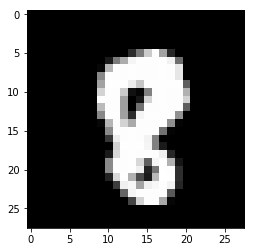

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def showIm(ix, x_test, y_test):
    image = (x_test[ix] * 255).reshape((28, 28)).astype("uint8")
    print("Actual digit is", y_test[ix])
    imgplot = plt.imshow(image)
    imgplot.set_cmap('gray')   

#print("Predict value with DEC is, ", dec.predict(x_test[img].reshape(1, 28,28,1)).argmax(1)[0])
showIm(2050, x_test, y_test)

('Predict value with DEC is, ', 3)
('Actual digit is', 6)


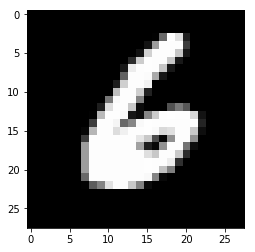

In [40]:
img = 9989
print("Predict value with DEC is, ", dec.predict(x_test[img].reshape(1, 28,28,1)).argmax(1)[0])
showIm(img, x_test, y_test)

In [41]:
spark.stop()